In [1]:
import os
import pathlib
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow.keras.regularizers as regularizers

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.`

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ["dlopen(/Users/joseph

In [2]:
DATASET_PATH = '/Users/joseph/Desktop/tensorflow-test/newer-audio'

data_dir = pathlib.Path(DATASET_PATH)

In [3]:
commands = ["real", "fake"]
print('Commands:', commands)

Commands: ['real', 'fake']


In [4]:
fake_filefolders = tf.io.gfile.glob(str(data_dir) + '/fake/*')
real_filefolders = tf.io.gfile.glob(str(data_dir) + '/real/*')
fake_filefolders = tf.random.shuffle(fake_filefolders)
real_filefolders = tf.random.shuffle(real_filefolders)

filefolders = []
filenames = []

for i in range(len(real_filefolders)): # hardcoded because real_filenames is the smaller sample set
    filefolders.append(real_filefolders[i].numpy().decode())
    filefolders.append(fake_filefolders[i].numpy().decode())

for i in range(len(filefolders)):
    filenames.append((tf.io.gfile.glob(filefolders[i] + '/*')))
    
filenames = tf.concat([item for item in filenames], axis = 0)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.glob(str(data_dir) + "/" + commands[0] + '/*/*')))
print(filenames)

2022-01-13 22:40:16.191246: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-13 22:40:16.191454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
Number of total examples: 140800
Number of examples per label: 70400
tf.Tensor(
[b'/Users/joseph/Desktop/tensorflow-test/newer-audio/real/file19236.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/bothshift_audio.wav'
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/real/file19236.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/pitch_audio.wav'
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/real/file19236.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/noisebothshift_audio.wav'
 ...
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/fake/file1161.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/noisepitch_audio.wav'
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/fake/file1161.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/time_audio.wav'
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/fake/file1161.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/audio.wav'], shape=(140800,), dtype=string)


In [5]:
train_files = filenames[:round(num_samples*0.8)]
val_files = filenames[round(num_samples*0.8): round(num_samples*0.9)]
test_files = filenames[round(num_samples*0.9):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 112640
Validation set size 14080
Test set size 14080


In [6]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-3]

In [8]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label
# waveform here is a tf tensor with 32000 values

In [9]:
def make_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 32000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [input_len] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tfio.audio.spectrogram(equal_length, nfft = 2048, window = 512, stride = 256)
  mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)  
  dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
  dbscale_mel_spectrogram = dbscale_mel_spectrogram[..., tf.newaxis]
  return dbscale_mel_spectrogram

In [10]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  # log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = spectrogram.shape[0]
  width = spectrogram.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, spectrogram)
  # plt.figure()
  # plt.imshow(tf.math.log(spectrogram).numpy())

In [11]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = make_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [12]:
def freq_masking(spectrogram, label_id):
    spectrogram = tf.squeeze(spectrogram)
    freq_mask = tfio.audio.freq_mask(spectrogram, param=10)   
    freq_mask = freq_mask[..., tf.newaxis]
    return freq_mask, label_id

In [13]:
def time_masking(spectrogram, label_id):
    spectrogram = tf.squeeze(spectrogram)
    time_mask = tfio.audio.time_mask(spectrogram, param=10)
    time_mask = time_mask[..., tf.newaxis]
    return time_mask, label_id

In [14]:
def specaugment(spectrogram, label_id):
        augmented_spec, label_id = freq_masking(spectrogram, label_id)
        augmented_spec, label_id = time_masking(augmented_spec, label_id)
        return augmented_spec, label_id

In [15]:
def normalize_ds(spectrogram, label_id):
    spectrogram = spectrogram + abs(tf.math.reduce_min(spectrogram))
    spectrogram = spectrogram / tf.math.reduce_max(spectrogram)
    return spectrogram, label_id

In [16]:
def preprocess_dataset(files):
  AUTOTUNE = tf.data.AUTOTUNE
    
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  spectrogram_ds = waveform_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  # specaugment_ds = spectrogram_ds.map(
  #     map_func=specaugment,
  #     num_parallel_calls=AUTOTUNE)
  # second_output_ds = spectrogram_ds.concatenate(specaugment_ds)
  output_ds = spectrogram_ds.map(
      map_func=normalize_ds,
      num_parallel_calls=AUTOTUNE)

  output_ds = output_ds.cache().prefetch(AUTOTUNE)
  
  num_elements = tf.data.experimental.cardinality(output_ds).numpy()
  print(num_elements)

  output_ds = output_ds.shuffle(num_elements)
    
  return output_ds

In [17]:
# all_ds = preprocess_dataset(filenames)

# num_elements = tf.data.experimental.cardinality(all_ds).numpy()

# train_size = int(0.8*num_elements)
# val_size = int(0.1*num_elements)
# test_size = int(0.1*num_elements)

# train_ds = all_ds.take(train_size)
# test_ds = all_ds.skip(train_size)
# val_ds = test_ds.skip(test_size)
# test_ds = test_ds.take(test_size)

In [18]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

112640
14080
14080


In [19]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [20]:
input_shape = (125, 128, 1)

model = models.Sequential([
    
    # same as modelv3 but 16 kernels per instead of 32
    
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(),
    
    
    layers.Dropout(0.3),
    
    layers.Flatten(),
    # layers.Dense(1024, activation='relu'),
    # layers.Dense(512, activation='relu'),
    # layers.Dense(256, activation='relu'),
    # layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 63, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 63, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 61, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 31, 16)       0         
 2D)                                                             
                                                        

In [21]:
checkpoint_path = "/Users/joseph/Desktop/tensorflow-test/checkpoints/modelv6.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=12)

tqdm_callback = tfa.callbacks.TQDMProgressBar()

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.losses.binary_crossentropy,
    metrics=['accuracy'],
)

In [23]:
model.load_weights(checkpoint_path)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    verbose=1,
    callbacks=[cp_callback, stopping_callback, lr_callback],
)

Epoch 1/100


2022-01-13 22:40:51.292058: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-13 22:40:51.292908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-13 22:41:02.177818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 930 of 112640
2022-01-13 22:41:12.172706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2016 of 112640
2022-01-13 22:41:22.212944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 3064 of 112640
2022-01-13 22:41:32.168305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4014 of 112640
2022-01-13 22:41:42.321908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this

3520/3520 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9816

2022-01-13 23:07:35.532817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-13 23:07:45.634884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1898 of 14080
2022-01-13 23:07:55.700807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 3355 of 14080
2022-01-13 23:08:05.618065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4940 of 14080
2022-01-13 23:08:15.630399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 6674 of 14080
2022-01-13 23:08:25.613369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 8719 of 14080
2022-01-13 23:08:35.629644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Fill


Epoch 00001: saving model to /Users/joseph/Desktop/tensorflow-test/checkpoints/modelv6.ckpt
3520/3520 [==============================] - 1697s 161ms/step - loss: 0.0744 - accuracy: 0.9816 - val_loss: 0.1296 - val_accuracy: 0.9633 - lr: 1.2500e-04
Epoch 2/100
3520/3520 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9808
Epoch 00002: saving model to /Users/joseph/Desktop/tensorflow-test/checkpoints/modelv6.ckpt
3520/3520 [==============================] - 542s 154ms/step - loss: 0.0763 - accuracy: 0.9808 - val_loss: 0.1148 - val_accuracy: 0.9687 - lr: 1.2500e-04
Epoch 3/100
3520/3520 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9814
Epoch 00003: saving model to /Users/joseph/Desktop/tensorflow-test/checkpoints/modelv6.ckpt
3520/3520 [==============================] - 560s 159ms/step - loss: 0.0751 - accuracy: 0.9814 - val_loss: 0.1162 - val_accuracy: 0.9673 - lr: 1.2500e-04
Epoch 4/100
3520/3520 [==============================] - ETA: 

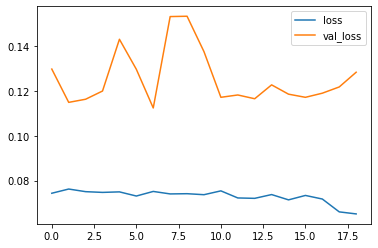

In [24]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [25]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'Test set accuracy: {test_acc:.0%}')

2022-01-14 01:54:58.475082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2697 of 14080
2022-01-14 01:55:08.482036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 5732 of 14080
2022-01-14 01:55:18.475910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 8807 of 14080
2022-01-14 01:55:28.464336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 11689 of 14080
2022-01-14 01:55:37.025091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


440/440 - 59s - loss: 0.1131 - accuracy: 0.9697 - 59s/epoch - 134ms/step
Test set accuracy: 97%


In [26]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.round(preds))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
# print(tf.cast(correct_labels, dtype=tf.float32) == tf.cast(predicted_labels, dtype=tf.float32))

2022-01-14 01:55:53.580954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


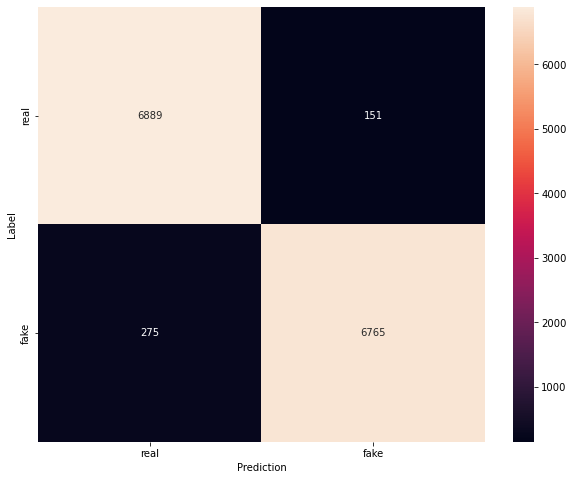

In [27]:
# y_pred = tf.cast(tf.round(model.predict(test_ds)), dtype=tf.float32)

# y_true = tf.cast(tf.concat([y for x, y in test_ds], axis=0), dtype=tf.float32)

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [28]:
save_path = "/Users/joseph/Desktop/tensorflow-test/saved-models/modelv6"
model.save(save_path)

2022-01-14 01:56:15.068349: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/joseph/Desktop/tensorflow-test/saved-models/modelv6/assets


In [31]:
import time

save_path = "/Users/joseph/Desktop/tensorflow-test/saved-models/modelv6"

new_model = tf.keras.models.load_model(save_path)

new_model.summary()

model = new_model

for i in range(11):

    t0 = time.time()
    loss, acc = new_model.evaluate(test_ds, verbose=2)
    t1 = time.time() 
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print(t1-t0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 63, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 63, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 61, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 31, 16)       0         
 2D)                                                             
                                                        

2022-01-14 04:40:39.382582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


440/440 - 6s - loss: 0.1131 - accuracy: 0.9697 - 6s/epoch - 13ms/step
Restored model, accuracy: 96.97%
5.855527877807617
440/440 - 4s - loss: 0.1131 - accuracy: 0.9697 - 4s/epoch - 9ms/step
Restored model, accuracy: 96.97%
3.8591370582580566
440/440 - 4s - loss: 0.1131 - accuracy: 0.9697 - 4s/epoch - 8ms/step
Restored model, accuracy: 96.97%
3.5657799243927
440/440 - 4s - loss: 0.1131 - accuracy: 0.9697 - 4s/epoch - 8ms/step
Restored model, accuracy: 96.97%
3.642329216003418
440/440 - 4s - loss: 0.1131 - accuracy: 0.9697 - 4s/epoch - 8ms/step
Restored model, accuracy: 96.97%
3.5576069355010986
440/440 - 4s - loss: 0.1131 - accuracy: 0.9697 - 4s/epoch - 8ms/step
Restored model, accuracy: 96.97%
3.5524699687957764
440/440 - 4s - loss: 0.1131 - accuracy: 0.9697 - 4s/epoch - 8ms/step
Restored model, accuracy: 96.97%
3.53460693359375
440/440 - 4s - loss: 0.1131 - accuracy: 0.9697 - 4s/epoch - 8ms/step
Restored model, accuracy: 96.97%
3.5762009620666504
440/440 - 4s - loss: 0.1131 - accuracy

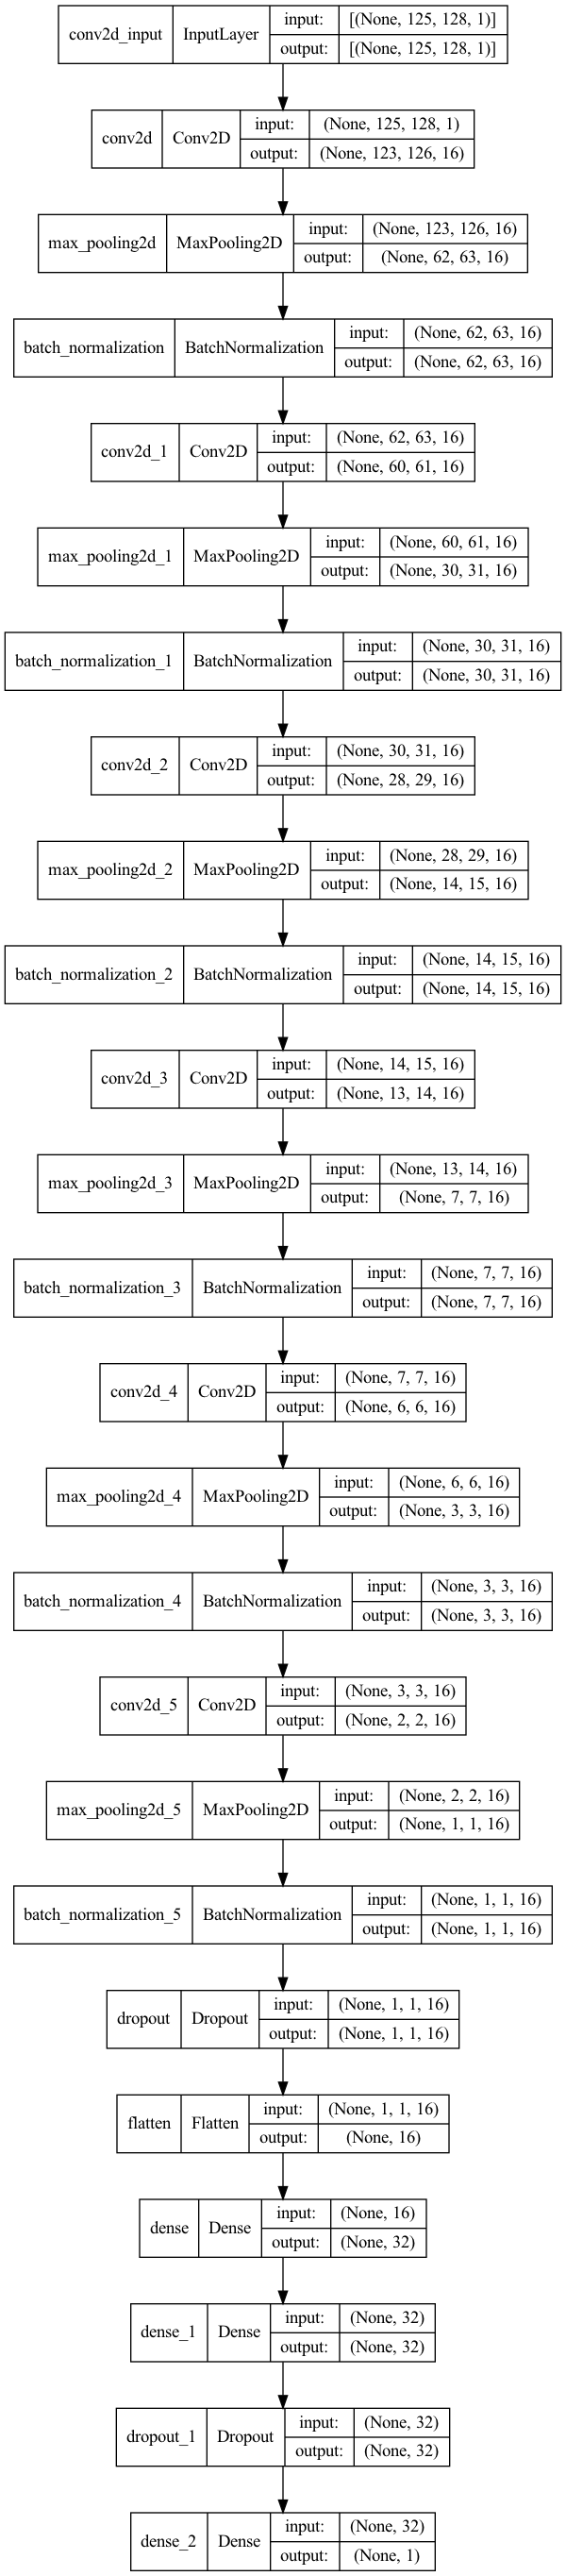

In [30]:
tf.keras.utils.plot_model(model, to_file="/Users/joseph/Desktop/tensorflow-test/architectures/modelv6_structure.png", show_shapes=True)